# Downloads and Views over time
In this notebook, we summarize download statistics we are collecting for the Zenodo records in our database. The code for this was AI-generated.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_file_and_date(filename):
    df = pd.read_csv(filename)
    date = pd.to_datetime(filename.replace("\\", "/").split("/")[-1].replace('.csv', ''), format='%Y%m%d')
    return df, date

In [3]:
folder_path = "../download_statistics/"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Sort the files by date
csv_files.sort()

dfs = []

# Process each file
for filename_old, filename_new in zip(csv_files[:-1], csv_files[1:]):
    # load data and determine timestampe
    df_old, date_old = read_file_and_date(folder_path + filename_old)
    df_new, date_new = read_file_and_date(folder_path + filename_new)
    
    # days difference
    days_diff = (date_new - date_old).days

    # Determine the rows in df_new where "url" values are also in df_old
    df_common = df_new[df_new['url'].isin(df_old['url'])]

    # Set the index to "url" for aligning them
    df_old_indexed = df_old.set_index("url")
    df_common_indexed = df_common.set_index("url")

    # Calculate the difference in the "download" column
    download_difference = df_common_indexed["unique_downloads"] - df_old_indexed["unique_downloads"]
    views_difference = df_common_indexed["unique_views"] - df_old_indexed["unique_views"]
    df_common_indexed = df_common_indexed[["authors"]]
    df_common_indexed["downloads_per_day"] = download_difference / days_diff
    df_common_indexed["views_per_day"] = views_difference / days_diff
    df_common_indexed["timestamp"] = date_new

    dfs.append(df_common_indexed)

df = pd.concat(dfs)
df = df.sort_values(by='downloads_per_day', ascending=False)
df = df.reset_index()
df.head()

,url,authors,downloads_per_day,views_per_day,timestamp
0,https://zenodo.org/records/13680725,"""Nicolas Chiaruttini""",37.857143,0.857143,2024-12-10
1,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",24.857143,73.285714,2024-12-10
2,https://zenodo.org/records/12623730,"""Haase, Robert""",19.142857,1.571429,2024-11-12
3,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",19.000000,3.857143,2024-11-26
4,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03


## Most downloaded document ever
Document with most downloads per day observed ever:

In [4]:
df["url"][0]

'https://zenodo.org/records/13680725'

## Most viewed document ever

In [5]:
df = df.sort_values(by='views_per_day', ascending=False)
df = df.reset_index()
df.head()

,index,url,authors,downloads_per_day,views_per_day,timestamp
0,1,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",24.857143,73.285714,2024-12-10
1,5,https://zenodo.org/records/14032908,"""Steuerungsgremium Allianz-Schwerpunkt and Ale...",14.571429,19.428571,2024-11-19
2,17,https://zenodo.org/records/14032908,"""Steuerungsgremium Allianz-Schwerpunkt and Ale...",9.714286,14.285714,2024-11-26
3,6,https://zenodo.org/records/14001044,"""Haase, Robert""",13.714286,12.857143,2024-11-05
4,9,https://zenodo.org/records/11521029,"""Geiger, Jonathan and Steiner, Petra and Desou...",12.857143,12.285714,2024-12-10


In [6]:
columns = df.columns

## Plotting downloads per day over time

In [7]:
df = df.sort_values(by='downloads_per_day', ascending=False)
df = df.reset_index()
df.head()

,level_0,index,url,authors,downloads_per_day,views_per_day,timestamp
0,241,0,https://zenodo.org/records/13680725,"""Nicolas Chiaruttini""",37.857143,0.857143,2024-12-10
1,0,1,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",24.857143,73.285714,2024-12-10
2,145,2,https://zenodo.org/records/12623730,"""Haase, Robert""",19.142857,1.571429,2024-11-12
3,56,3,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",19.000000,3.857143,2024-11-26
4,42,4,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03


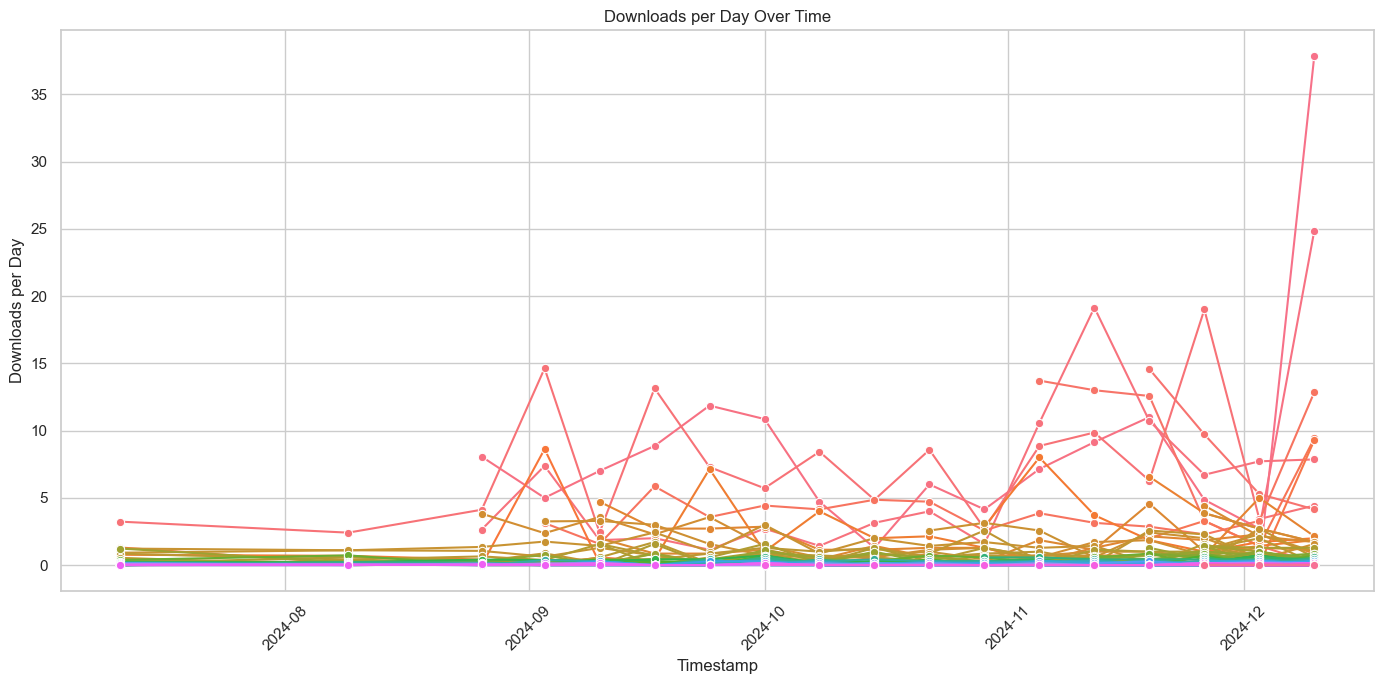

In [8]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create the line plot without legend
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='timestamp', y='downloads_per_day', hue='url', marker='o', legend=False)

# Add title and labels
plt.title('Downloads per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Downloads per Day')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

Three most downloaded items last week:

In [9]:
last_week = df[df["timestamp"] == df["timestamp"].max()]
url = last_week["url"][:3]
url

0    https://zenodo.org/records/13680725
1    https://zenodo.org/records/11201216
9    https://zenodo.org/records/11521029
Name: url, dtype: object

## Plotting views per day over time

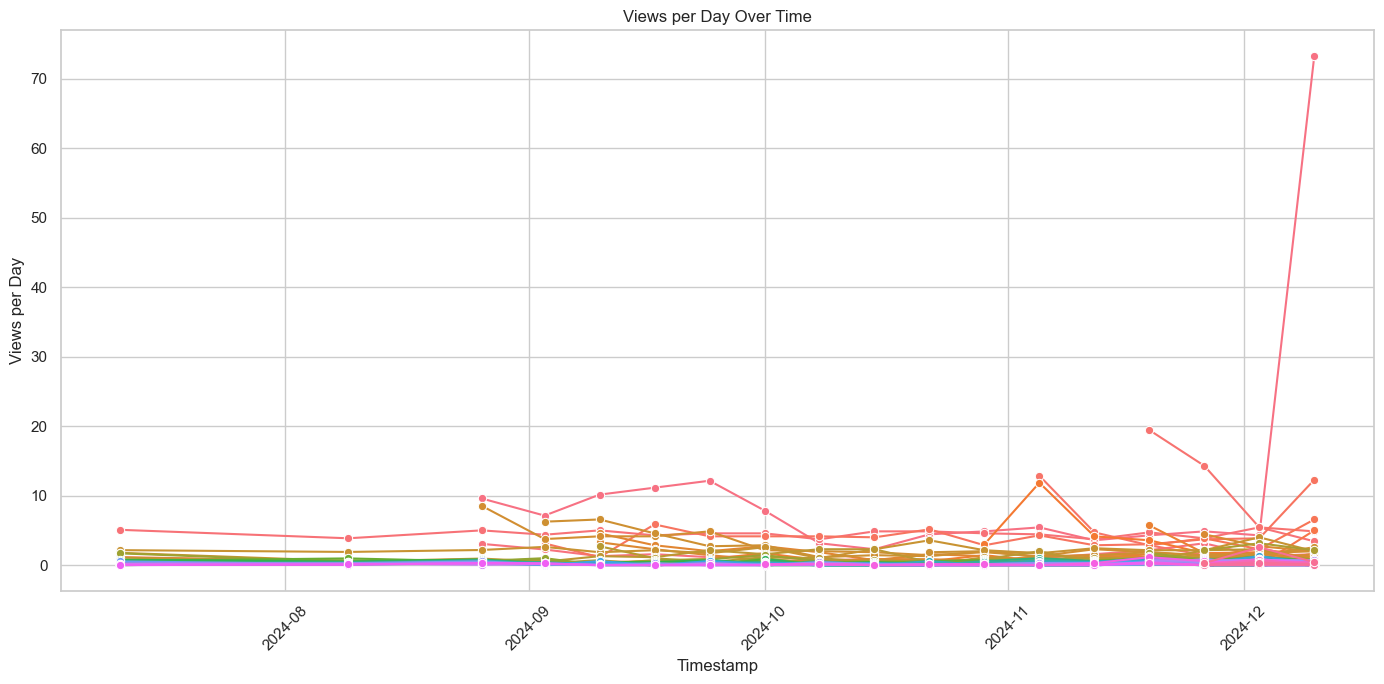

In [10]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create the line plot without legend
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='timestamp', y='views_per_day', hue='url', marker='o', legend=False)

# Add title and labels
plt.title('Views per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Views per Day')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

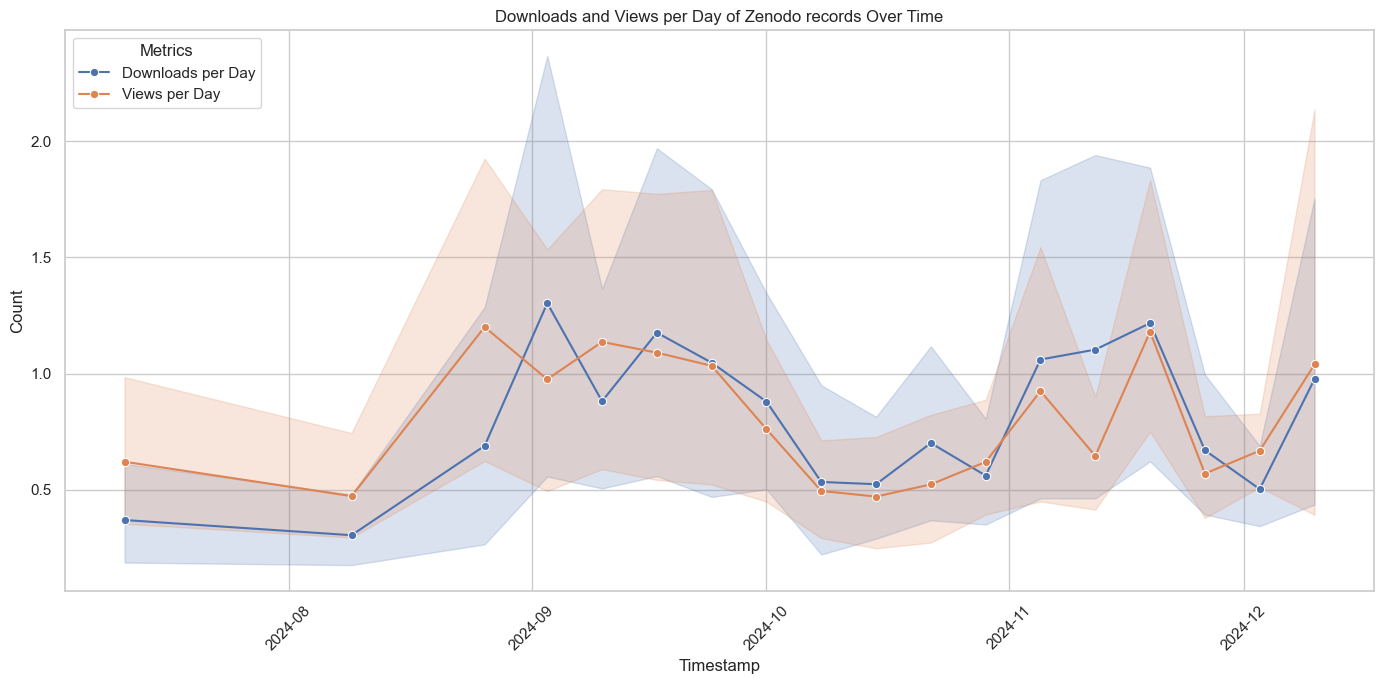

In [11]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a line plot for both 'downloads_per_day' and 'views_per_day'
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='downloads_per_day', data=df, label='Downloads per Day', marker='o')
sns.lineplot(x='timestamp', y='views_per_day', data=df, label='Views per Day', marker='o')

# Add title and labels
plt.title('Downloads and Views per Day of Zenodo records Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Add a legend to differentiate the lines
plt.legend(title='Metrics', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.savefig("../docs/statistics/downloads_and_views_over_time.png", dpi=700)
plt.show()

Three most views items last week:

In [12]:
last_week = df[df["timestamp"] == df["timestamp"].max()]
last_week = last_week.sort_values(by='views_per_day', ascending=False)
url = last_week["url"][:3]
url

1     https://zenodo.org/records/11201216
9     https://zenodo.org/records/11521029
18     https://zenodo.org/records/8305531
Name: url, dtype: object

## Viewing downloads and views for specific documents

In [13]:
df_doc = df[df["url"] == "https://zenodo.org/records/8323588"]
df_doc

,level_0,index,url,authors,downloads_per_day,views_per_day,timestamp
3,56,3,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",19.000000,3.857143,2024-11-26
4,42,4,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03
7,46,7,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",13.142857,4.285714,2024-09-17
16,61,16,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",9.857143,3.714286,2024-11-12
21,41,22,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",8.857143,4.428571,2024-11-05
24,26,24,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",8.571429,4.857143,2024-10-22
25,62,25,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",8.428571,3.714286,2024-10-08
31,36,31,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",7.285714,4.571429,2024-09-24
37,32,37,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",6.285714,4.714286,2024-11-19
40,34,40,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",5.714286,4.571429,2024-10-01


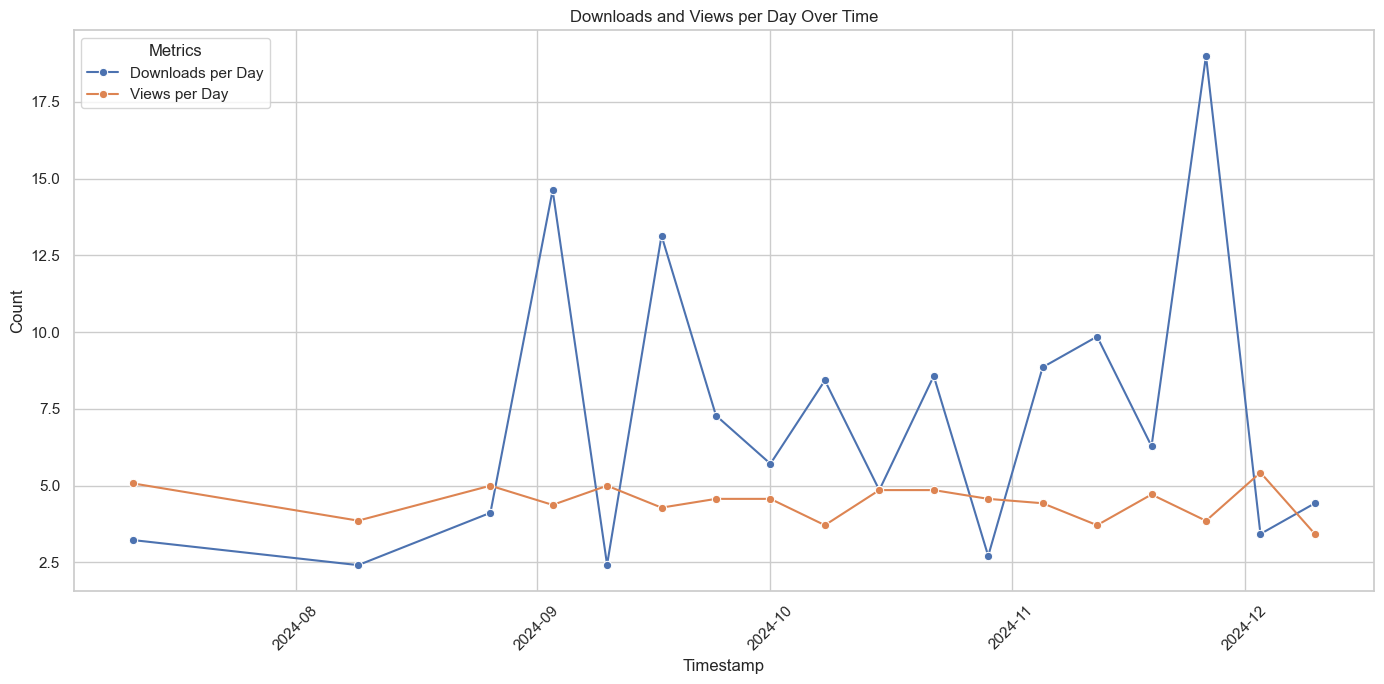

In [14]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a line plot for both 'downloads_per_day' and 'views_per_day'
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='downloads_per_day', data=df_doc, label='Downloads per Day', marker='o')
sns.lineplot(x='timestamp', y='views_per_day', data=df_doc, label='Views per Day', marker='o')

# Add title and labels
plt.title('Downloads and Views per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Add a legend to differentiate the lines
plt.legend(title='Metrics', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [15]:
import bia_bob

In [16]:
# Assuming `df` has a 'timestamp' column
#df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure timestamp is in datetime format
record_counts = df.groupby(df['timestamp'].dt.to_period('D')).size().reset_index(name='counts')
record_counts["timestamp"] = [str(d) for d in record_counts["timestamp"]]
record_counts

,timestamp,counts
0,2024-07-11,34
1,2024-08-09,34
2,2024-08-26,37
3,2024-09-03,40
4,2024-09-10,43
5,2024-09-17,43
6,2024-09-24,43
7,2024-10-01,59
8,2024-10-08,59
9,2024-10-15,59


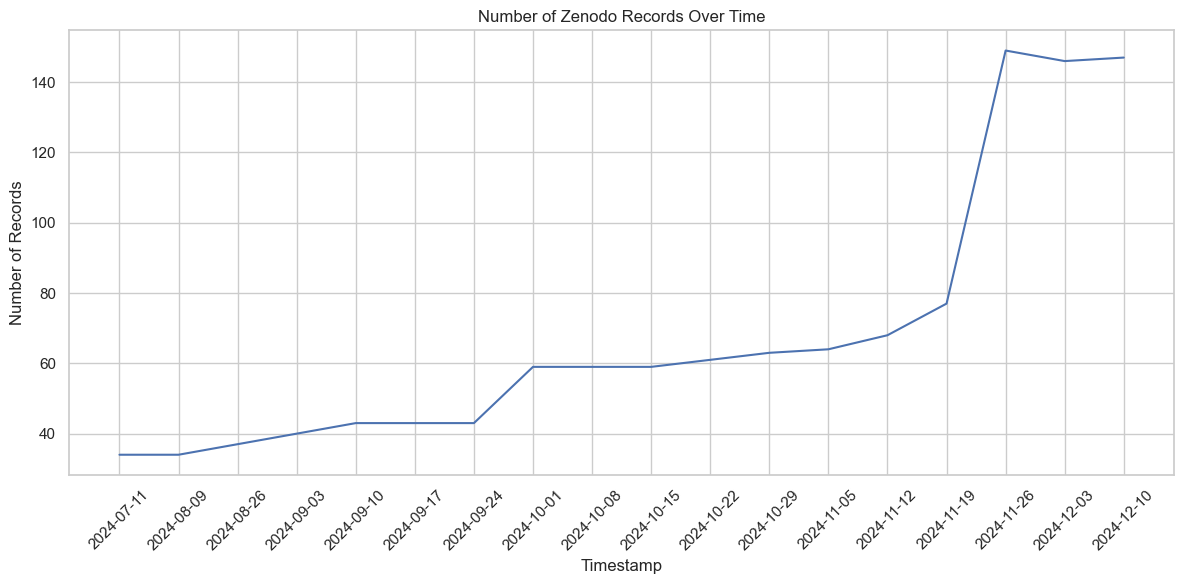

In [17]:
# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='timestamp', y='counts', data=record_counts)
plt.title('Number of Zenodo Records Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../docs/statistics/number_of_zenodo_records_over_time.png", dpi=700)
plt.show()